In [1]:
import os
from multiprocessing import Pool
from itertools import product

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Consts

ITEM_FEATURES = {
    "score": "model_scores/scores_train.bin",
    "rank": "item_train_ranks.bin",
    "log_rank": "item_train_log_ranks.bin"
}

build_cmd_template = (
    "./RPG --mode base --baseSize 1000000 --trainQueries 1000 "
    "--base data/{dataset}/data/{itemFeatures} "
    "--outputGraph {graphPath} "
    "--relevanceVector {relevanceVector} --efConstruction {efConstruction} --M 8 "
    "--metric {metricType}"
)

search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/{dataset}/data/model_scores/scores_{datasetPart}.bin --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK 5 --output data/{dataset}/result.txt --gtQueries 1000 --gtTop 100 "
    "--groundtruth data/{dataset}/data/model_scores/{groundtruth}.bin"
)

In [29]:
# exp config

# METRIC_PARAMS = list(product(["l1", "l2"], ["score", "rank", "log_rank"])) + [("min_sum", "rank")]
# METRIC_PARAMS = [("min_sum", "rank")]
METRIC_PARAMS = [
    ("top_sum --sumOrd 0", "rank"),
    ("top_sum --sumOrd 1", "rank"),
    ("top_sum --sumOrd 2", "rank"),
    ("top_sum --sumOrd 5", "rank"),
    ("top_sum --sumOrd 10", "rank"),
    ("top_sum --sumOrd 20", "rank"),
    ("top_sum --sumOrd 50", "rank"),
#     ("top_sum --sumOrd 100", "rank"),
#     ("top_sum --sumOrd 200", "rank"),
#     ("min_sum", "rank"),
    ("l2", "score"),
    ("l2", "rank"),
    ("l2", "log_rank"),
#     ("l1", "score"),
#     ("l1", "rank"),
#     ("l1", "log_rank")
]

dataset = "video"
dataset_part = "test"
efConstruction = 1000
relevanceVector = 1000 # length of relevance vector
efSearchTicks = list(np.exp(np.linspace(np.log(10), np.log(10000), 16)).astype("int"))
n_search_threads = 16

assert dataset_part in ["train", "test"]

In [30]:
def bench_cmd(cmd):
    res = {}
    with os.popen(cmd) as out:
        for line in out:
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res

def measure_performance(graph, dataset, ef_ticks, n_threads=8):
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(
            inputGraph=graph,
            dataset=dataset,
            efSearch=ef,
            datasetPart=dataset_part,
            groundtruth="groundtruth" if dataset_part == "test" else "groundtruth_train"
        ))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    output = {"relevance": [], "recall": [], "time": [], "evals": []}
    for i, res in enumerate(results):
        if all(key in res for key in output):
            for key in output:
                output[key].append(res[key])
        else:
            print("missed result for {} efSearch {}.".format(graph, ef_ticks[i]))
    return output

In [31]:
def get_graph_label(metric_type, feature_type):
    return metric_type.replace(" ", "_").replace("-", "") + "_" + feature_type

In [32]:
# build graphs
for metric_type, feature_type in METRIC_PARAMS:
    # build graph
    graph_path = "data/{}/{}_graph_rel{}ef{}.out".format(
        dataset, get_graph_label(metric_type, feature_type),
        relevanceVector, efConstruction
    )
    if not os.path.isfile(graph_path):
        build_cmd = build_cmd_template.format(
            graphPath=graph_path,
            dataset=dataset,
            itemFeatures=ITEM_FEATURES[feature_type],
            efConstruction=efConstruction,
            relevanceVector=relevanceVector,
            metricType=metric_type
        )
        print(build_cmd)
        os.system(build_cmd)
        print("Graph for {} metric and {} features is built".format(metric_type, feature_type))
        print()

In [33]:
# measure performance of graphs
results = {}
for metric_type, feature_type in METRIC_PARAMS:
    graph_path = "data/{}/{}_graph_rel{}ef{}.out".format(
        dataset, get_graph_label(metric_type, feature_type),
        relevanceVector, efConstruction
    )
    graph_label = get_graph_label(metric_type, feature_type)
    results[graph_label] = measure_performance(graph_path, dataset, efSearchTicks, n_threads=n_search_threads)

In [34]:
def plot_results(results, x_data="evals", y_data="recall"):
    plt.xlabel(x_data)
    plt.ylabel(y_data)
#     plt.xlim([1000, 20000])
#     plt.ylim([0.8, 1])
    plt.xscale('log')
#     plt.yscale('log')
    for label, stats in results.items():
        plt.plot(stats[x_data], stats[y_data], label=label)
        plt.scatter(stats[x_data], stats[y_data], s=10)
    plt.legend()
    plt.show()

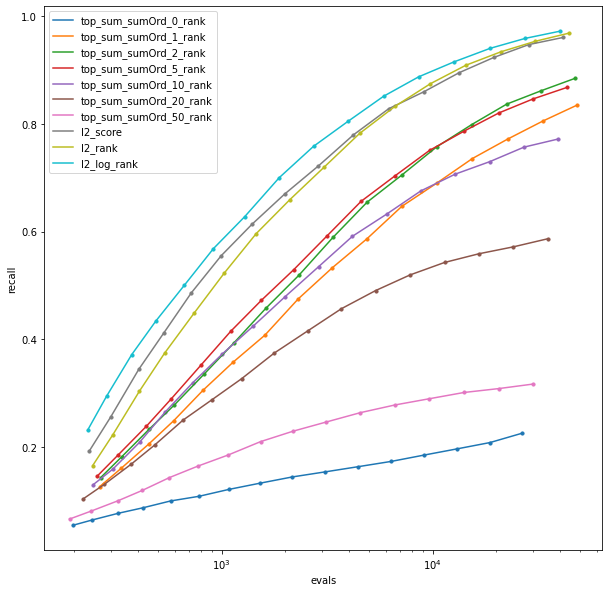

In [35]:
plt.figure(figsize=(10, 10))
plot_results(results)